<a href="https://colab.research.google.com/github/imanhamid/selectionscan_NN/blob/master/segmentation_firstpass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [3]:
path = Path(base_dir + 'data/segmentation/segmentation/')

In [42]:
'''
import os
images = "images"
dest = '/content/gdrive/My Drive/fastai-v3/data/segmentation/segmentation/images'
files = os.listdir(path)

for source in files:
    if source.endswith("_alltracts.png"):
        fullpath = "/content/gdrive/My Drive/fastai-v3/data/segmentation/segmentation/" + source
        shutil.move(fullpath, dest)
'''

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

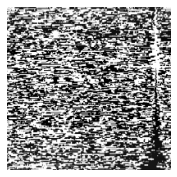

In [6]:
img_f = fnames[6000]
img = open_image(img_f)
img.show()

In [7]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

print(get_y_fn(img_f))

/content/gdrive/My Drive/fastai-v3/data/segmentation/segmentation/labels/const-10000_single-pulse_gen-100_m-0.5_pos-90814306_t-1_s-0.0103101812768728_seed-9831_alltracts_P.png


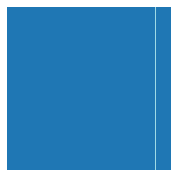

In [10]:
mask = open_mask(get_y_fn(img_f), div=True)
mask.show(alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([200, 200]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [13]:
codes = np.array(['neutral', 'sweep'], dtype=str)

In [14]:
free = gpu_mem_get_free_no_cache()
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")



using bs=8, have 16270MB of GPU RAM free


In [27]:
mask_opener=partial(open_mask, div=True)

In [33]:
class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [28]:
src = (SegItemListCustom.from_folder(path_img)
        .split_subsets(train_size = 0.08, valid_size = 0.1)
        .label_from_func(get_y_fn, classes=codes))
data = (src.databunch(bs=bs)
        .normalize())

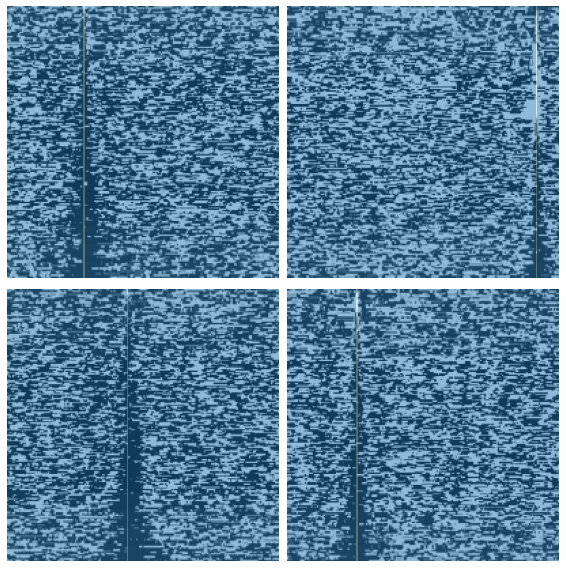

In [35]:
data.show_batch(2)

In [36]:
learn = unet_learner(data, models.resnet18, metrics=dice, wd=1e-2)

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


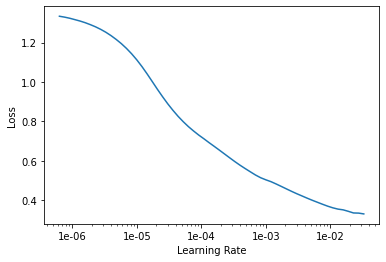

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
lr = 3e-5

In [39]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.279150,0.081709,0.005065,08:27
1,0.085372,0.048460,0.000791,00:22
2,0.039238,0.026764,0.004238,00:22
3,0.024796,0.020800,0.010729,00:22
4,0.019749,0.017937,0.025927,00:22
5,0.017216,0.016115,0.024954,00:22
6,0.015362,0.014785,0.092410,00:22
7,0.014190,0.014162,0.110704,00:22
8,0.013268,0.013400,0.130896,00:22
9,0.012375,0.013126,0.128341,00:22


In [41]:
learn.unfreeze()

In [42]:
lrs = slice(lr/400, lr/4)

In [43]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.011645,0.013229,0.121187,00:23
1,0.011543,0.013286,0.123762,00:23
2,0.011536,0.013271,0.125932,00:23
3,0.011453,0.013403,0.114488,00:23
4,0.011417,0.013215,0.134551,00:23
5,0.011222,0.013533,0.133613,00:23
6,0.011088,0.013564,0.187234,00:23
7,0.010869,0.013542,0.218083,00:23
8,0.010712,0.014086,0.176723,00:23
9,0.010438,0.014040,0.164221,00:23


In [45]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.009391,0.014349,0.222532,00:23
1,0.009438,0.014657,0.228172,00:23
2,0.009478,0.015156,0.224340,00:23
3,0.009492,0.014643,0.226358,00:23
4,0.009450,0.015011,0.241344,00:23
5,0.009386,0.015034,0.277987,00:23
6,0.009318,0.015524,0.245111,00:23
7,0.009289,0.015041,0.260996,00:23
8,0.009189,0.014697,0.213250,00:23
9,0.009089,0.014890,0.270335,00:23


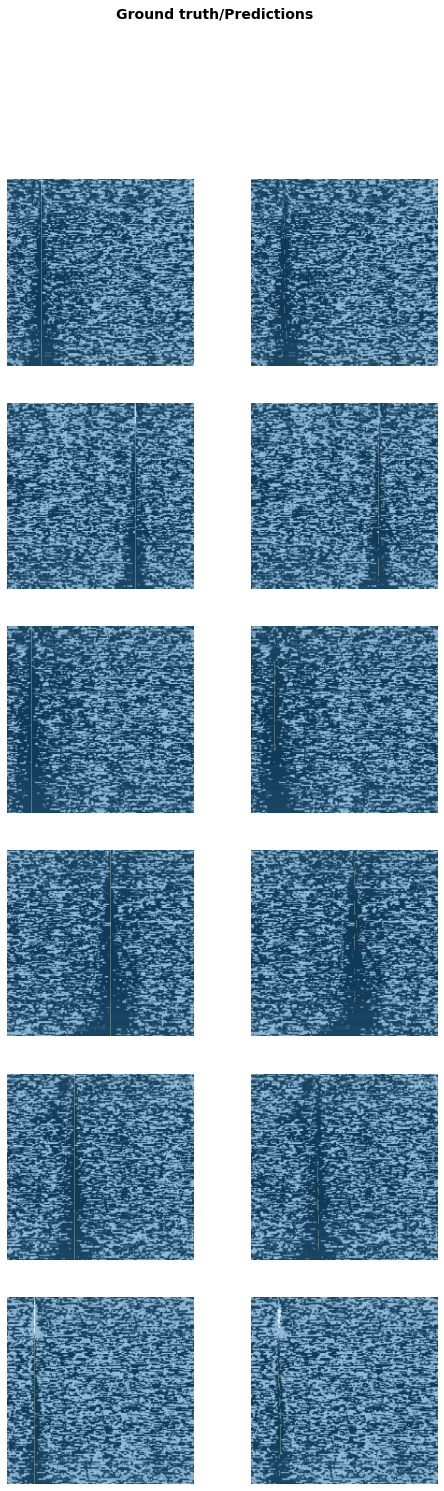

In [46]:
learn.show_results(rows=6)

In [48]:
class SegmentationInterpretation(Interpretation):
    "Interpretation methods for segmenatation models."
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor,
                 ds_type:DatasetType=DatasetType.Valid):
        super(SegmentationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.argmax(dim=1)
        self.c2i = {c:i for i,c in enumerate(self.data.classes)}
        self.i2c = {i:c for c,i in self.c2i.items()}
    
    def top_losses(self, sizes:Tuple, k:int=None, largest=True):
        "Reduce flatten loss to give a single loss value for each image"
        losses = self.losses.view(-1, np.prod(sizes)).mean(-1)
        return losses.topk(ifnone(k, len(losses)), largest=largest)
    
    def _interp_show(self, ims:ImageSegment, classes:Collection=None, sz:int=20, cmap='tab20',
                    title_suffix:str=None):
        "Show ImageSegment with color mapping labels"
        fig,axes=plt.subplots(1,2,figsize=(sz,sz))
        np_im = to_np(ims.data).copy()
        # tab20 - qualitative colormaps support max of 20 distinc colors
        # if len(classes) > 20 close idxs map to same color
        # image
        if classes is not None:
            class_idxs = [self.c2i[c] for c in classes]
            mask = np.max(np.stack([np_im==i for i in class_idxs]),axis=0)
            np_im = (np_im*mask).astype(np.float)
            np_im[np.where(mask==0)] = np.nan
        im=axes[0].imshow(np_im[0], cmap=cmap)

        # labels
        np_im_labels = list(np.unique(np_im[~np.isnan(np_im)]))
        c = len(np_im_labels); n = math.ceil(np.sqrt(c))
        label_im = np.array(np_im_labels + [np.nan]*(n**2-c)).reshape(n,n)
        axes[1].imshow(label_im, cmap=cmap)
        for i,l in enumerate([self.i2c[l] for l in np_im_labels]):
            div,mod=divmod(i,n)
            l = "\n".join(wrap(l,10)) if len(l) > 10 else l
            axes[1].text(mod, div, f"{l}", ha='center', color='white', fontdict={'size':sz})

        if title_suffix:
            axes[0].set_title(f"{title_suffix}_imsegment")
            axes[1].set_title(f"{title_suffix}_labels")

    def show_xyz(self, i, classes:list=None, sz=10):
        'show (image, true and pred) from self.ds with color mappings, optionally only plot'
        x,y = self.ds[i]
        self.ds.show_xys([x],[y], figsize=(sz/2,sz/2))
        self._interp_show(ImageSegment(self.y_true[i]), classes, sz=sz, title_suffix='true')
        self._interp_show(ImageSegment(self.pred_class[i][None,:]), classes, sz=sz, title_suffix='pred')

    def _generate_confusion(self):
        "Average and Per Image Confusion: intersection of pixels given a true label, true label sums to 1"
        single_img_confusion = []
        mean_confusion = []
        n =  self.pred_class.shape[0]
        for c_j in range(self.data.c):
            true_binary = self.y_true.squeeze(1) == c_j
            total_true = true_binary.view(n,-1).sum(dim=1).float()
            for c_i in range(self.data.c):
                pred_binary = self.pred_class == c_i
                total_intersect = (true_binary*pred_binary).view(n,-1).sum(dim=1).float()
                p_given_t = (total_intersect / (total_true))
                p_given_t_mean = p_given_t[~torch.isnan(p_given_t)].mean()
                single_img_confusion.append(p_given_t)
                mean_confusion.append(p_given_t_mean)
        self.single_img_cm = to_np(torch.stack(single_img_confusion).permute(1,0).view(-1, self.data.c, self.data.c))
        self.mean_cm = to_np(torch.tensor(mean_confusion).view(self.data.c, self.data.c))
        return self.mean_cm, self.single_img_cm

    def _plot_intersect_cm(self, cm, title="Intersection with Predict given True"):
        "Plot confusion matrices: self.mean_cm or self.single_img_cm generated by `_generate_confusion`"
        from IPython.display import display, HTML
        fig,ax=plt.subplots(1,1,figsize=(10,10))
        im=ax.imshow(cm, cmap="Blues")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"{title}")
        ax.set_xticks(range(self.data.c))
        ax.set_yticks(range(self.data.c))
        ax.set_xticklabels(self.data.classes, rotation='vertical')
        ax.set_yticklabels(self.data.classes)
        fig.colorbar(im)
        
        df = (pd.DataFrame([self.data.classes, cm.diagonal()], index=['label', 'score'])
            .T.sort_values('score', ascending=False))
        with pd.option_context('display.max_colwidth', pd_max_colwidth()):
            display(HTML(df.to_html(index=False)))
        return df

In [49]:
interp = SegmentationInterpretation.from_learner(learn)

In [50]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
neutral,0.998316
sweep,0.21722


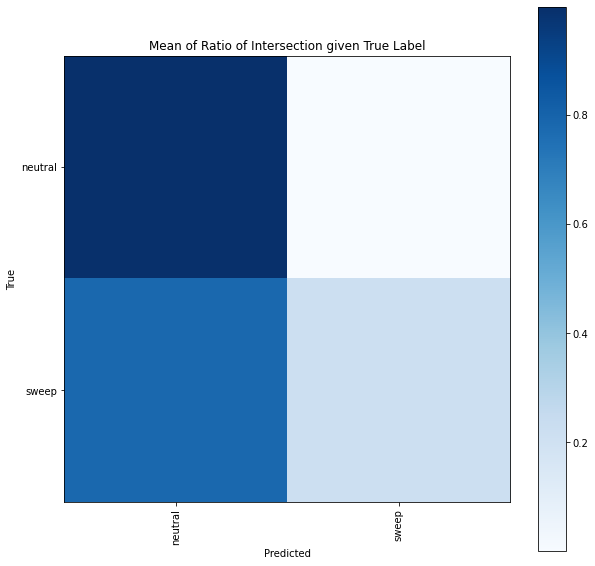

In [51]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [63]:
t = interp.pred_class[3]
print((t==1).nonzero())

tensor([[  4, 110],
        [  5, 110],
        [  6, 110],
        [ 10, 110],
        [ 14, 110],
        [ 15, 110],
        [ 16, 110],
        [ 18, 110],
        [ 20, 111],
        [ 21, 111],
        [ 22, 110],
        [ 22, 111],
        [ 23, 110],
        [ 23, 111],
        [ 24, 110],
        [ 24, 111],
        [ 25, 110],
        [ 25, 111],
        [ 26, 110],
        [ 26, 111],
        [ 27, 110],
        [ 28, 110],
        [ 29, 110],
        [ 31, 110],
        [ 32, 110],
        [ 33, 110],
        [ 34, 110],
        [ 35, 110],
        [ 36, 110],
        [ 37, 110],
        [ 38, 110],
        [ 39, 110],
        [ 42, 110],
        [ 56, 110],
        [ 57, 110],
        [ 58, 110],
        [ 59, 110],
        [ 60, 110],
        [ 61, 110],
        [ 62, 110],
        [ 63, 110],
        [ 64, 110],
        [ 65, 110],
        [ 66, 110],
        [ 67, 110],
        [ 68, 110],
        [ 68, 111],
        [ 69, 110],
        [ 69, 111],
        [ 70, 110],


In [64]:
t2 = interp.y_true[3]
print((t2==1).nonzero())

tensor([[  0,   0, 110],
        [  0,   1, 110],
        [  0,   2, 110],
        [  0,   3, 110],
        [  0,   4, 110],
        [  0,   5, 110],
        [  0,   6, 110],
        [  0,   7, 110],
        [  0,   8, 110],
        [  0,   9, 110],
        [  0,  10, 110],
        [  0,  11, 110],
        [  0,  12, 110],
        [  0,  13, 110],
        [  0,  14, 110],
        [  0,  15, 110],
        [  0,  16, 110],
        [  0,  17, 110],
        [  0,  18, 110],
        [  0,  19, 110],
        [  0,  20, 110],
        [  0,  21, 110],
        [  0,  22, 110],
        [  0,  23, 110],
        [  0,  24, 110],
        [  0,  25, 110],
        [  0,  26, 110],
        [  0,  27, 110],
        [  0,  28, 110],
        [  0,  29, 110],
        [  0,  30, 110],
        [  0,  31, 110],
        [  0,  32, 110],
        [  0,  33, 110],
        [  0,  34, 110],
        [  0,  35, 110],
        [  0,  36, 110],
        [  0,  37, 110],
        [  0,  38, 110],
        [  0,  39, 110],


In [65]:
learn.save('stage-1')